<a href="https://colab.research.google.com/github/NavaneethSivadas025/DWtut/blob/main/RegressionHealthCalculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2024-06-22 17:40:38--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2024-06-22 17:40:38 (4.64 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
features=['age','sex','children','bmi','smoker']
X=dataset[features]
y=dataset['expenses']
X['agebmiratio']=X['age']/X['bmi']
X['childrenageratio']=X['children']/X['age']
X['childrenbmiratio']=X['children']/X['bmi']
X['sex_smoker']=X['sex']+'_'+X['smoker']
train_data,test_data,train_labels,test_labels=train_test_split(X,y,test_size=0.2,random_state=5)

s = (train_data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

train_dataset=train_data.copy()
test_dataset=test_data.copy()


ordinalencoder=OrdinalEncoder()
train_dataset[object_cols]=ordinalencoder.fit_transform(train_dataset[object_cols])
test_dataset[object_cols]=ordinalencoder.transform(test_dataset[object_cols])
train_dataset = train_dataset.astype({'age': 'float32', 'children': 'float32'})
test_dataset = test_dataset.astype('float32')
scaler = RobustScaler()
train_dataset_scaled = scaler.fit_transform(train_dataset)
test_dataset_scaled = scaler.transform(test_dataset)
model=tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu', input_shape=[9]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])
model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['mae','mse'])
early_stopping=EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

def remove_outliers(df, labels, z_thresh=3):
    from scipy import stats
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < z_thresh).all(axis=1)
    return df[filtered_entries], labels[filtered_entries]

train_dataset,train_labels=remove_outliers(train_dataset,train_labels)

model.fit(train_dataset,train_labels,epochs=500,batch_size=50,validation_data=(test_dataset,test_labels),callbacks=[early_stopping])


<ipython-input-17-576fc5f7cb09>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['agebmiratio']=X['age']/X['bmi']


Categorical variables:
['sex', 'smoker', 'sex_smoker']
Epoch 1/500
21/21 [==============================] - 3s 42ms/step - loss: 13499.0801 - mae: 13499.0801 - mse: 329422784.0000 - val_loss: 12444.9580 - val_mae: 12444.9580 - val_mse: 306604096.0000
Epoch 2/500
21/21 [==============================] - 0s 5ms/step - loss: 13430.1104 - mae: 13430.1104 - mse: 327460384.0000 - val_loss: 12313.5918 - val_mae: 12313.5918 - val_mse: 303087968.0000
Epoch 3/500
21/21 [==============================] - 0s 6ms/step - loss: 13156.0352 - mae: 13156.0352 - mse: 319802144.0000 - val_loss: 11830.6680 - val_mae: 11830.6680 - val_mse: 290465760.0000
Epoch 4/500
21/21 [==============================] - 0s 6ms/step - loss: 12262.8252 - mae: 12262.8252 - mse: 294965664.0000 - val_loss: 10421.2979 - val_mae: 10421.2979 - val_mse: 255947712.0000
Epoch 5/500
21/21 [==============================] - 0s 8ms/step - loss: 10148.1006 - mae: 10148.1006 - mse: 241614080.0000 - val_loss: 8079.4478 - val_mae: 8079.44

9/9 - 0s - loss: 1742.1398 - mae: 1742.1398 - mse: 19194554.0000 - 59ms/epoch - 7ms/step
Testing set Mean Abs Error: 1742.14 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 4ms/step


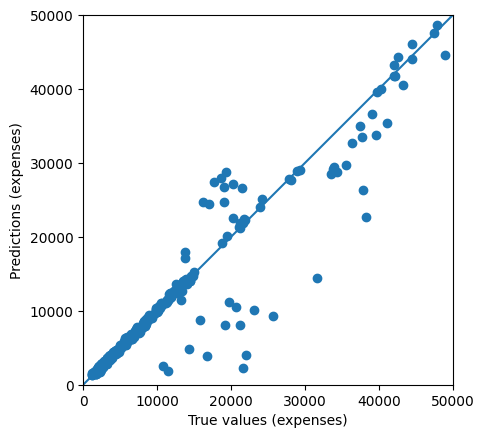

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
